# SEIR Model for COVID-19 Forecasting

In [47]:
# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from bayes_opt import BayesianOptimization
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Other
import copy
from datetime import datetime, timedelta
import os
import random
import sys
from typing import List, Tuple

# Custom module
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.plotting import plot_predictions
from src.utils import get_covid_data
from ygg_seir_simulator.fixed_params import *
from ygg_seir_simulator.learn_simulation import *
from ygg_seir_simulator.region_model import RegionModel
from ygg_seir_simulator.simulation import run, predict
from ygg_seir_simulator.util import str_to_date, remove_space_region

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## Purpose

The goal is to produce accurate forecasts of COVID-19 deaths and infections in Canada. One of the models we'll be focusing on is an SEIR model using a simulator based off of https://covid19-projections.com/model-details/.  

## Load Data and EDA

For the data we'll only be using mortality data as cases data can be innacurate and add noise to the model. The dataset can be found here https://github.com/ishaberry/Covid19Canada.

In [48]:
# Read in data
mortality_provinces = pd.read_csv(
    "../data/timeseries_prov/mortality_timeseries_prov.csv"
)
active_cases_provinces = pd.read_csv(
    "../data/timeseries_prov/active_timeseries_prov.csv"
)

# Simple preprocessing
format = "%d-%m-%Y"
mortality_provinces = mortality_provinces.assign(
    date_death_report=lambda x: pd.to_datetime(
        x["date_death_report"], format=format
    ).dt.date
)

active_cases_provinces = active_cases_provinces.assign(
    date_active=lambda x: pd.to_datetime(x["date_active"], format=format).dt.date
).assign(cumulative_removed=lambda x: x["cumulative_cases"] + x["cumulative_recovered"])

# Get first and last day of death reports
mortality_start_date = mortality_provinces["date_death_report"].min()
mortality_end_date = mortality_provinces["date_death_report"].max()

# Get list of provinces
provinces = mortality_provinces["province"].unique()

# Filter for Ontario
mortality_ontario = mortality_provinces.query('province == "Ontario"')

mortality_provinces.head(10)

,province,date_death_report,deaths,cumulative_deaths
0,Alberta,2020-03-08,0,0
1,Alberta,2020-03-09,0,0
2,Alberta,2020-03-10,0,0
3,Alberta,2020-03-11,0,0
4,Alberta,2020-03-12,0,0
5,Alberta,2020-03-13,0,0
6,Alberta,2020-03-14,0,0
7,Alberta,2020-03-15,0,0
8,Alberta,2020-03-16,0,0
9,Alberta,2020-03-17,0,0


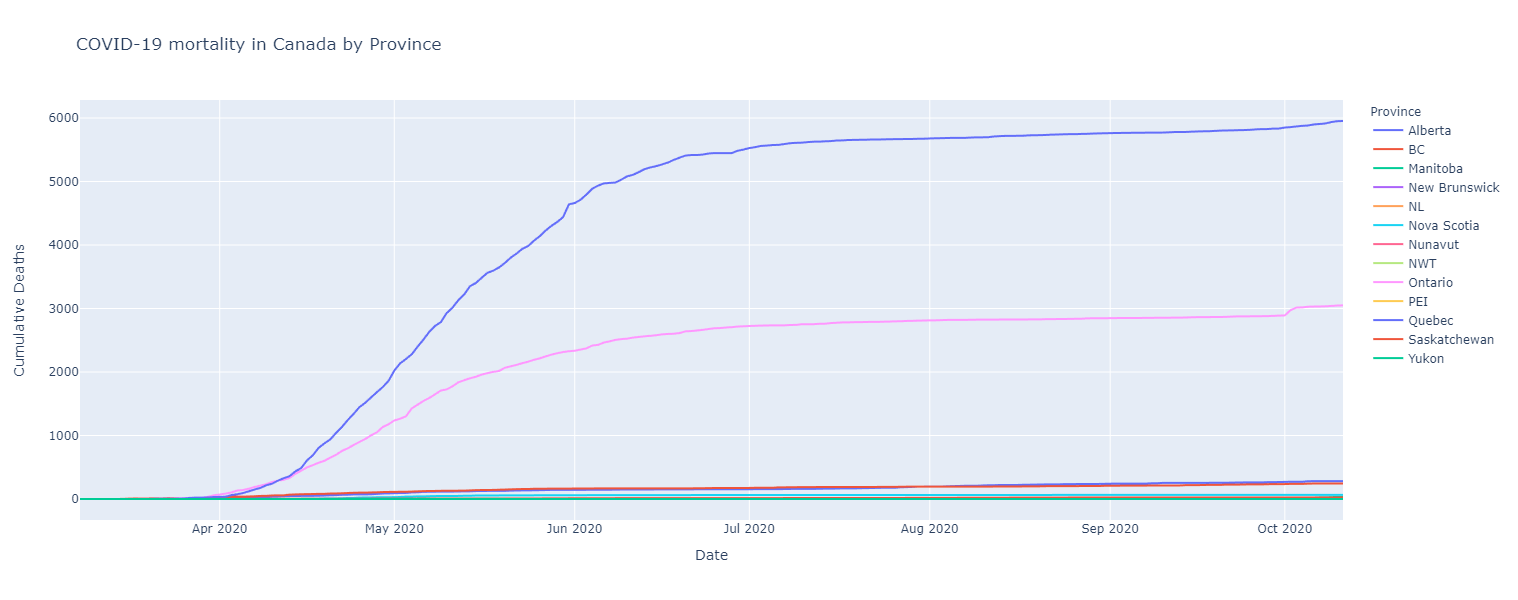

In [49]:
fig = px.line(
    mortality_provinces,
    x="date_death_report",
    y="cumulative_deaths",
    color="province",
    title="COVID-19 mortality in Canada by Province",
    labels=dict(
        date_death_report="Date",
        cumulative_deaths="Cumulative Deaths",
        province="Province",
    ),
    height=600,
)
fig.show()

### Comments

- From the mortalities plot above it seems like Quebec and Ontario make up the majority of covid mortalities in Canada. They greatly increase at the start and then slow down and are currently starting to level out
- The other provinces have much lower growth in deaths. Zooming in we see a mostly linear pattern
- All the provinces have their date death reports on the same day March 8, 2020

## SEIR Parameter Estimation

First we would want to replace the simple grid search layer in the original model with more sophisticated optimization methods. The parameters we'll be tuning are:

- Mortality rate
- Initial $R_0$
- Lockdown $R_0$
- Imports of positive cases per day

To handle overfitting we'll be applying cross-validation. Since we are dealing with time series we will split our data a bit differently. The data will be split into folds in order from 1 to k and for each $i$ from 1 to k we will use train the model on the first 1 to i folds and validate on the remaining folds. For our loss function we'll be using root mean squared error (RMSE) on the cumulative sum of deaths.

In [50]:
# Set argument values
skip_hospitalizations = None
quarantine_perc = 0
quarantine_effectiveness = -1
best_params_type = "mean"
country = "Canada"
region = "ALL"
subregion = "Ontario"
best_params_dir = "../models/best_params/latest"

# Set start and end dates
simulation_start_date = mortality_start_date - timedelta(days=DAYS_BEFORE_DEATH)
simulation_create_date = datetime.date(year=2020, month=10, day=1)
simulation_end_date = datetime.date(year=2020, month=11, day=1)

# Load parameters from file. This contains both fixed and variable parameters. We will not use the given variable parameters however
region_params, params_dict = load_best_params_province(best_params_dir, "Ontario")

# Create base region model
region_model = RegionModel(
    country,
    region,
    subregion,
    simulation_start_date,
    simulation_create_date,
    simulation_end_date,
    region_params,
    compute_hospitalizations=(not skip_hospitalizations),
)

# Dataframe to store cross validation scores
cv_scores = pd.DataFrame(columns=["province", "method", "fold", "rmse"])

Loading params file: ../models/best_params/latest/subregion\Canada_Ontario.json


In [51]:
def loss(
    variable_params: Tuple,
    params: dict,
    region_model: RegionModel,
    mortality_data: pd.DataFrame,
) -> float:
    """
    Helper function for calculting root mean squared error for SEIR model.
    The variable params should be (initial_r_0, lockdown_r_0, mortality_rate, daily_imports)
    """
    # Initialize parameters for region model
    (
        params["INITIAL_R_0"],
        params["LOCKDOWN_R_0"],
        params["MORTALITY_RATE"],
        params["DAILY_IMPORTS"],
    ) = variable_params
    params_tups = tuple(params_dict.items())
    region_model_copy = copy.deepcopy(region_model)
    region_model_copy.init_params(params_tups)

    # Run SEIR simulation
    mortality_pred = predict(region_model_copy, mortality_data)

    # Calculate rmse. Use only projections for known dates and not future forecasts
    mortality_pred = mortality_pred.query("cumulative_deaths == cumulative_deaths")
    deaths_true = mortality_pred["cumulative_deaths"]
    deaths_pred = mortality_pred["cumulative_deaths_pred"]

    rmse = np.sqrt(np.mean((deaths_true - deaths_pred) ** 2))

    return rmse

### L-BFGS-B Optimization

Bound constrained minimization implemented in scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [52]:
%%time

# Estimate optimal parameters using L-BFGS-B method in scipy
x0 = [1, 1, 0.01, 100]
bounds = [(1e-4, 10), (1e-4, 10), (1e-4, 0.2 - 1e-6), (0, 1000)]

optimal = minimize(
    loss,
    x0=x0,
    args=(params_dict, region_model, mortality_ontario),
    method="L-BFGS-B",
    bounds=bounds,
)

Wall time: 12.4 s


In [53]:
# Initialize parameters for region_model using estimated params
(
    params_dict["INITIAL_R_0"],
    params_dict["LOCKDOWN_R_0"],
    params_dict["MORTALITY_RATE"],
    params_dict["DAILY_IMPORTS"],
) = optimal.x
params_tups = tuple(params_dict.items())
region_model.init_params(params_tups)

# Run simulation and calculate loss
mortality_pred = predict(region_model, mortality_ontario)
rmse = loss(optimal.x, params_dict, region_model, mortality_ontario)
print(f"rmse: {rmse}\n")

rmse: 32.389026132308594



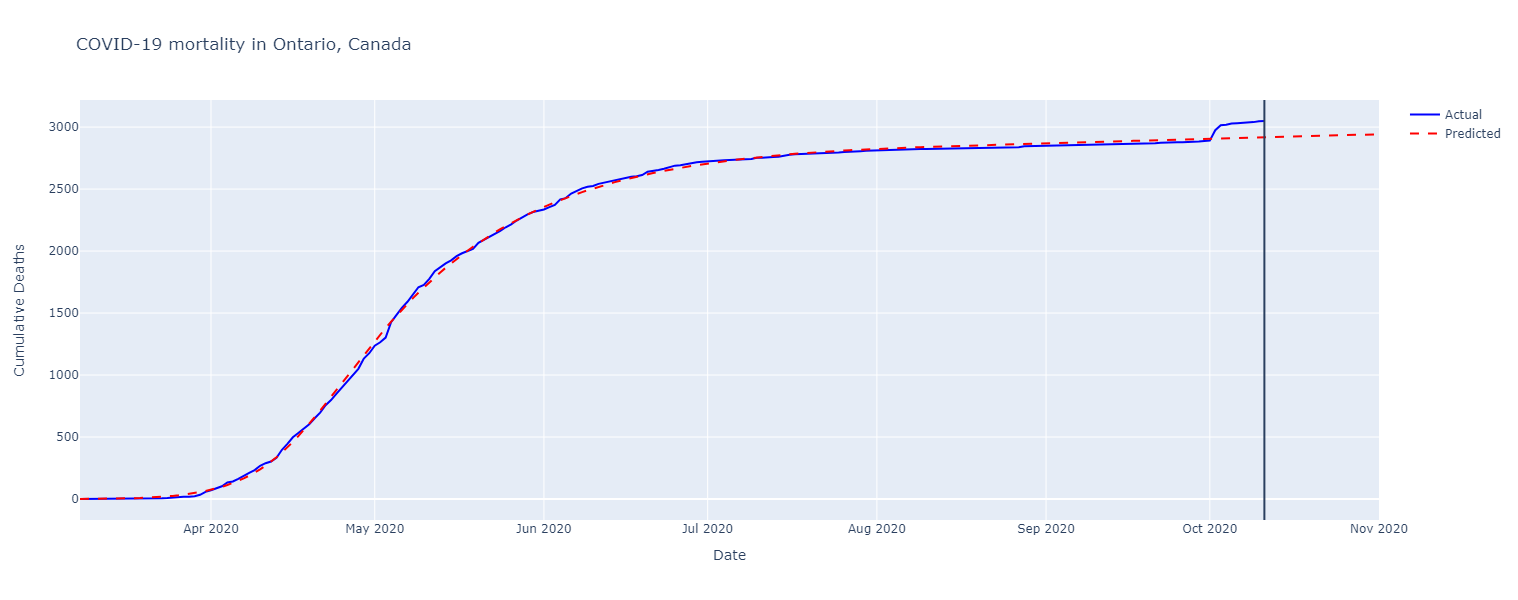

In [56]:
# Plot results
mortality_pred["date"] = mortality_pred["date_death_report"]
plot_predictions(
    mortality_pred,
    y="cumulative_deaths",
    y_label='Cumulative Deaths',
    title="COVID-19 mortality in Ontario, Canada",
    height=600
)

#### Cross validation scores

In [9]:
%%time

tscv = TimeSeriesSplit(n_splits=10)

# loop through each province and each split
for province in provinces:
    mortality_province = mortality_provinces.query('province == @province')
    
    for index, (train_index, test_index) in enumerate(tscv.split(mortality_province)):
        mortality_train = mortality_province.iloc[train_index]
        mortality_test = mortality_province.iloc[test_index]

        # Fit model to train set
        optimal = minimize(
            loss,
            x0=x0,
            args=(params_dict, region_model, mortality_train),
            method="L-BFGS-B",
            bounds=bounds,
        )

        # Initialize parameters
        (
            params_dict["INITIAL_R_0"],
            params_dict["LOCKDOWN_R_0"],
            params_dict["MORTALITY_RATE"],
            params_dict["DAILY_IMPORTS"],
        ) = optimal.x
        params_tups = tuple(params_dict.items())
        region_model.init_params(params_tups)

        # Run simulation and calculate loss
        mortality_pred = predict(region_model, mortality_province)
        mortality_pred = mortality_pred.iloc[test_index]

        rmse = mean_squared_error(mortality_test['cumulative_deaths'], mortality_pred['cumulative_deaths_pred'], squared=False)

        # Append results
        cv_scores = cv_scores.append({'province': province, 'method': 'l-bfgs-b', 'fold': index, 'rmse': rmse}, ignore_index=True)
        
        
# Save results
cv_scores.to_csv("../models/seir_cross_val_scores.csv", index=False)

Wall time: 12min 57s


In [23]:
# Average rmse scores
cv_scores.groupby(["province", "method"]).agg({"rmse": "mean"}).reset_index()

,province,method,rmse
0,Alberta,l-bfgs-b,46.564180
1,BC,l-bfgs-b,16.201173
2,Manitoba,l-bfgs-b,2.064727
3,NL,l-bfgs-b,1.430032
4,NWT,l-bfgs-b,0.000000
5,New Brunswick,l-bfgs-b,1.380642
6,Nova Scotia,l-bfgs-b,420.871239
7,Nunavut,l-bfgs-b,0.000000
8,Ontario,l-bfgs-b,292.024413
9,PEI,l-bfgs-b,0.000000


### Bayesian Optimization

In [48]:
%%time

# Setup parameters
pbounds = {
    "initial_r_0": (1e-4, 10),
    "lockdown_r_0": (1e-4, 10),
    "mortality_rate": (1e-4, 0.2 - 1e-6),
    "daily_imports": (0, 1000),
}

optimizer = BayesianOptimization(
    f=lambda initial_r_0, lockdown_r_0, mortality_rate, daily_imports: -loss(
        (initial_r_0, lockdown_r_0, mortality_rate, daily_imports),
        params_dict,
        region_model,
        mortality_ontario,
    ),
    pbounds=pbounds,
    verbose=1,
)

# # Some initial guess
# optimizer.probe(
#     params={
#         "initial_r_0": 2,
#         "lockdown_r_0": 1,
#         "mortality_rate": 0.01,
#         "daily_imports": 200,
#     },
#     lazy=True,
# )

# Run optimization
optimizer.maximize(
    init_points=100,
    n_iter=100,
)

|   iter    |  target   | daily_... | initia... | lockdo... | mortal... |
-------------------------------------------------------------------------
|  6        | -1.25e+04 |  229.1    |  1.242    |  0.8413   |  0.1449   |
|  52       | -2.274e+0 |  444.5    |  1.05     |  0.136    |  0.08641  |
|  106      | -532.1    |  445.5    |  0.05109  |  0.4841   |  0.1438   |
|  134      | -187.7    |  228.4    |  2.137    |  0.7014   |  0.0001   |
Wall time: 59.1 s


In [49]:
# Initialize parameplot_predictionsfor region_model using estimated params
max_params = optimizer.max["params"]
params_dict["INITIAL_R_0"] = max_params["initial_r_0"]
params_dict["LOCKDOWN_R_0"] = max_params["lockdown_r_0"]
params_dict["MORTALITY_RATE"] = max_params["mortality_rate"]
params_dict["DAILY_IMPORTS"] = max_params["daily_imports"]

params_tups = tuple(params_dict.items())
region_model.init_params(params_tups)

# Run simulation and calculate loss
mortality_pred = predict(region_model, mortality_ontario)
rmse = -optimizer.max["target"]
print(f"rmse: {rmse}")

rmse: 187.74690076612262


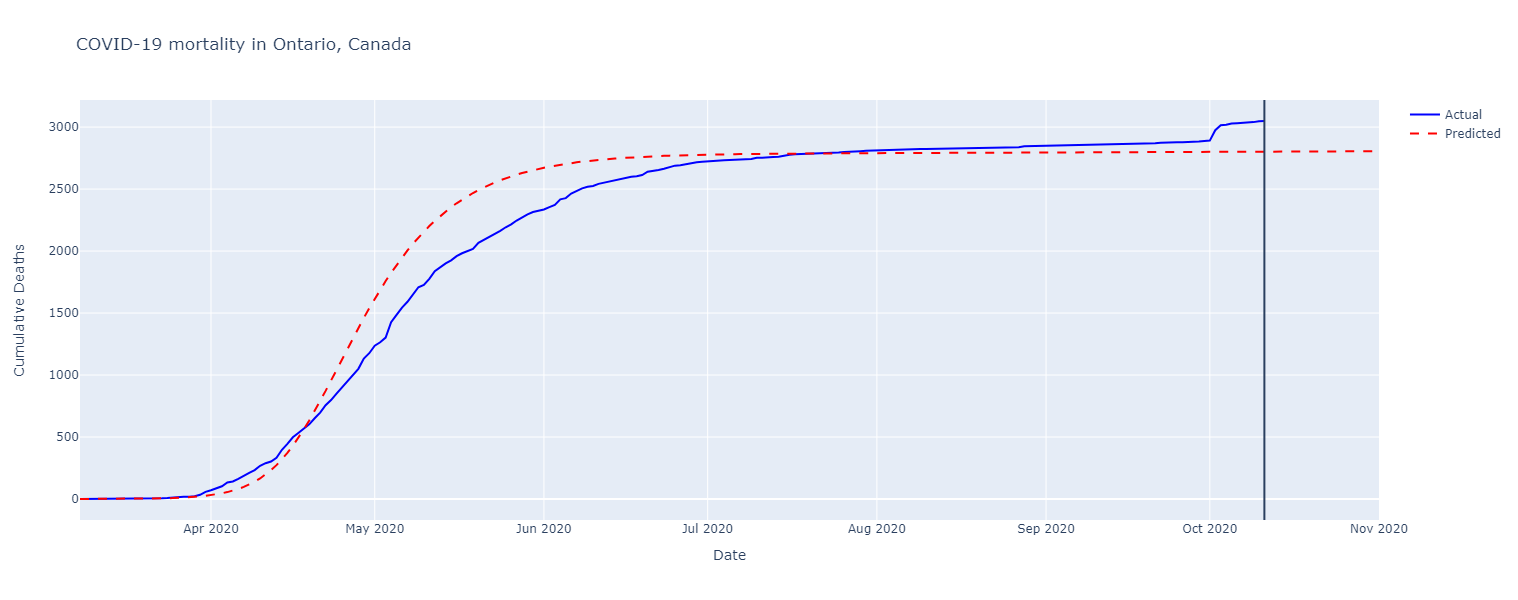

In [50]:
# Plot results
mortality_pred["date"] = mortality_pred["date_death_report"]
plot_predictions(
    mortality_pred,
    y="cumulative_deaths",
    y_label="Cumulative Deaths",
    title="COVID-19 mortality in Ontario, Canada",
)

#### Cross validation scores

In [61]:
%%time

tscv = TimeSeriesSplit(n_splits=10)

# loop through each province and each split
for province in provinces:
    mortality_province = mortality_provinces.query('province == @province')
    
    for index, (train_index, test_index) in enumerate(tscv.split(mortality_province)):
        mortality_train = mortality_province.iloc[train_index]
        mortality_test = mortality_province.iloc[test_index]

        # Fit model to train set
        optimizer = BayesianOptimization(
            f=lambda initial_r_0, lockdown_r_0, mortality_rate, daily_imports: -loss(
                (initial_r_0, lockdown_r_0, mortality_rate, daily_imports),
                params_dict,
                region_model,
                mortality_ontario,
            ),
            pbounds=pbounds,
            verbose=0,
        )
        
        # Run optimization
        optimizer.maximize(
            init_points=100,
            n_iter=100,
        )

        # Initialize parmaeters
        (
            params_dict["INITIAL_R_0"],
            params_dict["LOCKDOWN_R_0"],
            params_dict["MORTALITY_RATE"],
            params_dict["DAILY_IMPORTS"],
        ) = optimal.x
        params_tups = tuple(params_dict.items())
        region_model.init_params(params_tups)

        # Run simulation and calculate loss
        mortality_pred = predict(region_model, mortality_province)
        mortality_pred = mortality_pred.iloc[test_index]

        rmse = mean_squared_error(mortality_test['cumulative_deaths'], mortality_pred['cumulative_deaths_pred'], squared=False)

        # Append results
        cv_scores = cv_scores.append({'province': province, 'method': 'bayesian_opt', 'fold': index, 'rmse': rmse}, ignore_index=True)
        
    print(f'Completed {province}')
        
# Save results
cv_scores.to_csv("../models/seir_cross_val_scores.csv", index=False)

Completed Alberta
Completed BC
Completed Manitoba
Completed New Brunswick
Completed NL
Completed Nova Scotia
Completed Nunavut
Completed NWT
Completed Ontario
Completed PEI
Completed Quebec
Completed Saskatchewan
Completed Yukon
Wall time: 1h 38min 15s


In [64]:
# Average rmse scores
cv_scores.groupby(["province", "method"]).agg({"rmse": "mean"}).reset_index()

,province,method,rmse
0,Alberta,bayesian_opt,2171.937138
1,Alberta,l-bfgs-b,46.564180
2,BC,bayesian_opt,2171.055480
3,BC,l-bfgs-b,16.201173
4,Manitoba,bayesian_opt,2333.032923
5,Manitoba,l-bfgs-b,2.064727
6,NL,bayesian_opt,2339.895308
7,NL,l-bfgs-b,1.430032
8,NWT,bayesian_opt,2342.890611
9,NWT,l-bfgs-b,0.000000


### Grid search

In [ ]:

real_death = mortality_ontario['deaths'].tolist()
real_death_all = mortality_ontario['cumulative_deaths'].tolist()
real_date = mortality_end_date

In [34]:
# Set simulation parameters

params_tups = tuple(params_dict.items())
region_model.init_params(params_tups)
dates, infections, hospitalizations, deaths = run(region_model)

deaths_total = deaths.cumsum()
ind = np.where(dates == real_date)[0].item()
deaths_proj = deaths_total[: ind + 1]

if len(deaths_total[: ind + 1]) >= len(real_death_all):
    pad = len(deaths_proj) - len(real_death_all)
    real_death_all = np.array([0] * pad + real_death_all)

if len(real_death_all) > len(deaths_total[: ind + 1]):
    real_death_all = np.array(real_death_all)
    pad = len(real_death_all) - len(deaths_total[: ind + 1])
    deaths_proj = np.zeros(pad).extend(deaths_proj)
days = len(real_death_all)

best_error = 1 / days * sum((real_death_all - deaths_proj) ** 2)
MR = params_dict["MORTALITY_RATE"]  # =0.013
IR = params_dict["INITIAL_R_0"]  # =1.79

LR = params_dict["LOCKDOWN_R_0"]  # =0.76
DI = params_dict["DAILY_IMPORTS"]  # =160

In [ ]:
for params_dict["INITIAL_R_0"] in np.linspace(IR * 0.7, IR):
    for params_dict["LOCKDOWN_R_0"] in np.linspace(LR * 0.95, LR * 1.05, 20):
        for params_dict["DAILY_IMPORTS"] in np.linspace(DI, DI * 1.35):
            for params_dict["MORTALITY_RATE"] in np.linspace(
                MR * 1.5, MR * 2.5, 20
            ):
                params_tups = tuple(params_dict.items())
                region_model.init_params(params_tups)
                dates, infections, hospitalizations, deaths = run(region_model)
                deaths_total = deaths.cumsum()
                deaths_proj = deaths_total[: ind + 1]

                if len(real_death_all) > len(deaths_total[: ind + 1]):
                    real_death_all = np.array(real_death_all)
                    pad = len(real_death_all) - len(deaths_total[: ind + 1])
                    deaths_proj = np.zeros(pad).extend(deaths_total[: ind + 1])

                error = 1 / days * sum((real_death_all - deaths_proj) ** 2)
                if error <= best_error:
                    best_error = error
                    inf_proj, hosp_proj, death_proj = (
                        infections,
                        hospitalizations,
                        deaths,
                    )
                    best_parameters = {
                        "INITIAL_R_0": params_dict["INITIAL_R_0"],
                        "LOCKDOWN_R_0": params_dict["LOCKDOWN_R_0"],
                        "DAILY_IMPORTS": params_dict["DAILY_IMPORTS"],
                        "MORTALITY_RATE": params_dict["MORTALITY_RATE"],
                    }
                    print("Finding new optimum with error:", best_error)

print(best_parameters)

### Comments

## Final model results

## Confidence Intervals with Monte Carlo Method